In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from prophet import Prophet
from prophet.plot import plot_plotly

In [3]:
df = sns.load_dataset('flights')

In [4]:
df.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [5]:
df['Date'] = pd.to_datetime("01-" + df.month.astype(str) + df.year.astype(str))
df.head()

,year,month,passengers,Date
0,1949,Jan,112,1949-01-01
1,1949,Feb,118,1949-02-01
2,1949,Mar,132,1949-03-01
3,1949,Apr,129,1949-04-01
4,1949,May,121,1949-05-01


In [6]:
flights_df = df[['Date','passengers']] 

In [7]:
flights_df.head()

,Date,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
flights_df.columns = ['ds', 'y']

In [9]:
flights_df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


<Axes: xlabel='ds', ylabel='y'>

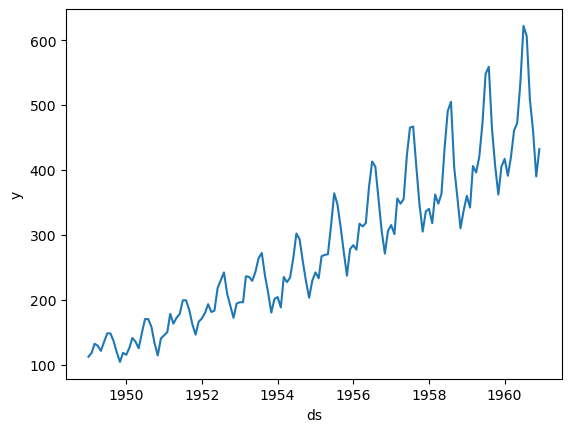

In [10]:
sns.lineplot(flights_df, x='ds', y='y')

- yearly seasonality 
- linear trend
- non constant variance

In [11]:
eighty_spot = int(0.8*flights_df.shape[0])

train_df = flights_df[:eighty_spot]
test_df = flights_df[eighty_spot:]

<Axes: xlabel='ds', ylabel='y'>

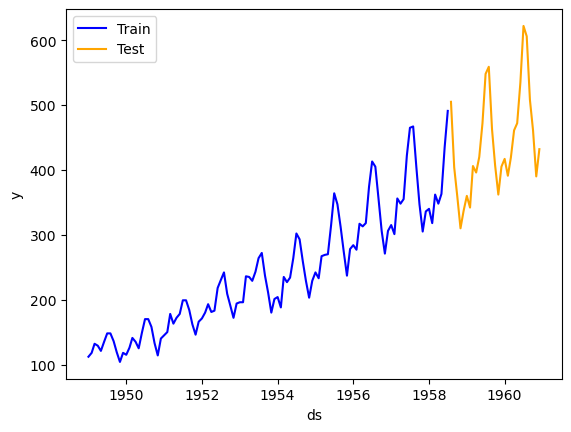

In [12]:
sns.lineplot(train_df, x='ds', y='y', c='b', label='Train')
sns.lineplot(test_df, x='ds', y='y', c='orange', label='Test')

In [13]:
m = Prophet(interval_width=0.95, yearly_seasonality=True, seasonality_mode='multiplicative')
model = m.fit(train_df)

17:35:24 - cmdstanpy - INFO - Chain [1] start processing
17:35:24 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
test_range_dates = m.make_future_dataframe(periods=test_df.shape[0], freq='M')
forecast = m.predict(test_range_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1949-01-01,117.015611,88.362046,122.254703,117.015611,117.015611,-0.094839,-0.094839,-0.094839,-0.094839,-0.094839,-0.094839,0.0,0.0,0.0,105.918006
1,1949-02-01,118.536403,84.451786,118.107059,118.536403,118.536403,-0.141471,-0.141471,-0.141471,-0.141471,-0.141471,-0.141471,0.0,0.0,0.0,101.766993
2,1949-03-01,119.910022,104.019251,137.114003,119.910022,119.910022,0.004086,0.004086,0.004086,0.004086,0.004086,0.004086,0.0,0.0,0.0,120.400016
3,1949-04-01,121.430814,100.256576,134.317165,121.430814,121.430814,-0.033145,-0.033145,-0.033145,-0.033145,-0.033145,-0.033145,0.0,0.0,0.0,117.406038
4,1949-05-01,122.902548,101.485092,136.354491,122.902548,122.902548,-0.029899,-0.029899,-0.029899,-0.029899,-0.029899,-0.029899,0.0,0.0,0.0,119.227899


In [15]:
plot_plotly(m, forecast)

In [16]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [17]:
rmse = np.sqrt(mean_squared_error(test_df['y'], forecast['yhat'][eighty_spot:]))
mape = mean_absolute_percentage_error(test_df['y'], forecast['yhat'][eighty_spot:])

print(f"Root MSE: {rmse}")
print(f"MAPE: {mape}")

Root MSE: 23.975750040252613
MAPE: 0.044013381558466264


<Axes: xlabel='ds', ylabel='y'>

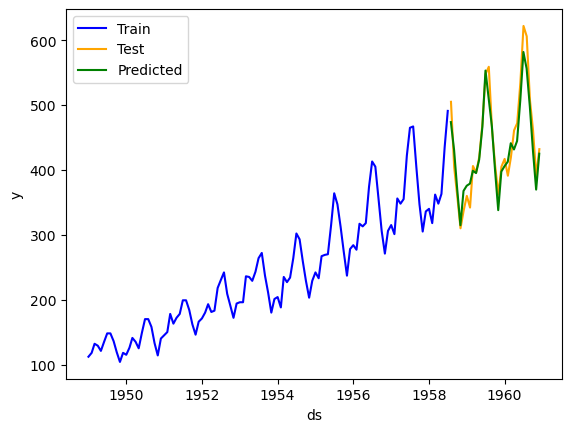

In [18]:
sns.lineplot(train_df, x='ds', y='y', c='b', label='Train')
sns.lineplot(test_df, x='ds', y='y', c='orange', label='Test')
sns.lineplot(forecast[eighty_spot:], x='ds', y='yhat', c='green', label='Predicted')

In [20]:
residuals = test_df['y'] - forecast['yhat'][eighty_spot:]

In [21]:
first_test_date = "1958-08-01"

prediction_dates = pd.DataFrame({'Date': pd.date_range(start=first_test_date, periods=test_df.shape[0], freq='M'), 'residuals': residuals})

[Text(-4110.0, 0, '1958-10'),
 Text(-4018.0, 0, '1959-01'),
 Text(-3928.0, 0, '1959-04'),
 Text(-3837.0, 0, '1959-07'),
 Text(-3745.0, 0, '1959-10'),
 Text(-3653.0, 0, '1960-01'),
 Text(-3562.0, 0, '1960-04'),
 Text(-3471.0, 0, '1960-07'),
 Text(-3379.0, 0, '1960-10'),
 Text(-3287.0, 0, '1961-01')]

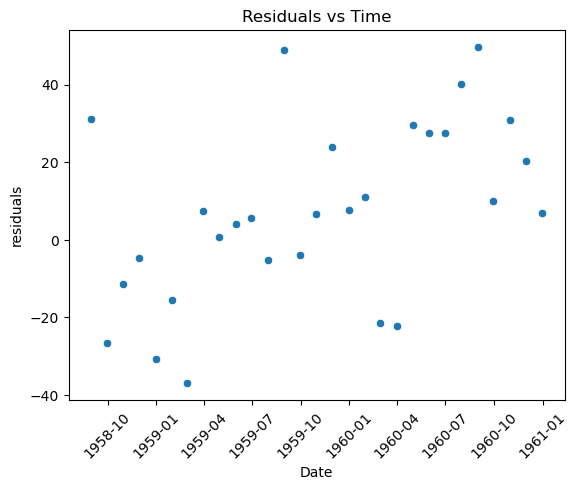

In [27]:
ax = sns.scatterplot(prediction_dates, x='Date', y='residuals')
ax.set_title("Residuals vs Time")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

There seems to be no persiting pattern in the residuals and thus the model is valid